## IMDb Dataset

the IMDB dataset is a set of 50,000 highly polarized reviews from the Internet movie database. These reviews are split into two, 25,000 for training and 25,000 for testing with each set consisting of 50% negative and 50% positive reviews. 

This dataset uses separate training and test sets because you should never test a machine learning model on the same data that you used to train it, as it could perform very differently on data that has not yet been seen. Therefore you care about a models performance on new data.

### Hypothesis
- The outputs can be predicted given the inputs
- The available data is sufficiently informative to learn the relationship between inputs and outputs


### Loading the dataset

In [1]:
#Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#Loading the IMDB dataset
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
num_words=10000)

The argument above, num_words=10000 means we will only keep the top 10,000 most frequesntly occuring words in the training data. Rare words will be discarded. This means we will be able to work with data of manageable size.

Variables train_data and test_data are the lists of reviews, where each review is a list of word indices.
train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive.

In [3]:
len(train_data)

25000

In [4]:
len(test_data)

25000

## Encoding

Encoding the integer sequences into a binary matrix

In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    #creates an all zero matrix of shape (len(sequences),(dimension))
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        #sets specific indices of results[i] to 1s
        results[i, sequence] = 1.
    return results

#Vectorised training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

#Vectorising the labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#setting aside a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [6]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import pandas as pd

# Model 1 - A 16 - 16 - 1 Model

Starting off with a simple model to see the results on the IMDB dataset. I will use advanced techniques such as embedding and conv1d to see how the results compare to this model.


### Building the Network

In [7]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])
history = model.fit(partial_x_train, 
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val)) 

Epoch 1/20
30/30 [==============================] - 1s 29ms/step - loss: 0.5284 - accuracy: 0.7900 - val_loss: 0.3988 - val_accuracy: 0.8717
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.3188 - accuracy: 0.8993 - val_loss: 0.3153 - val_accuracy: 0.8824
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2350 - accuracy: 0.9245 - val_loss: 0.2894 - val_accuracy: 0.8871
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1828 - accuracy: 0.9425 - val_loss: 0.2894 - val_accuracy: 0.8843
Epoch 5/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1492 - accuracy: 0.9520 - val_loss: 0.2793 - val_accuracy: 0.8869
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1195 - accuracy: 0.9625 - val_loss: 0.3092 - val_accuracy: 0.8789
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1001 - accuracy: 0.9704 - val_loss: 0.3041 - val_accuracy: 0.8844
Epoch 8/20
30

For a simple model like this, the estimated time taken for each epoch is less then 1 second for each one making it almost instant and extremely quick. 

### Main Results from this Model
| Highest Validation Loss | Lowest Validation Loss | Best Validation Accuracy | Worst Validation Accuracy |
|:-: |:-: |:-: |:-: |
| 0.7055 (Epoch 20) | 0.2793 (Epoch 5) | 0.8871 (Epoch 3) | 0.8664 (Epoch 16)

### Loss Graph

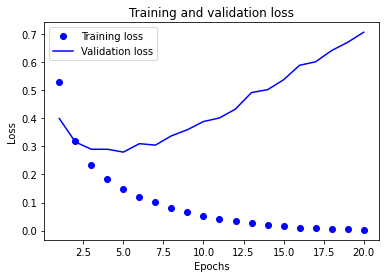

In [8]:
    import matplotlib.pyplot as plt


    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    # Code for the Labels
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

We can see that the training loss is always decreasing, despite it being slowed down heavily after the fifth epoch, whereas the validation loss peaks at around the fourth epoch and then increases very quickly. Here you are seeing overfitting, and after the second epoch, the model is overoptimizing on the training data. The optimum epoch for this would be around 3, so we could stop training after three epochs to prevent overfitting, however I will be using other techniques on this dataset to create the best version possible.

The **Optimum epoch** for the validation loss in this network is 5.

### Accuracy Graph

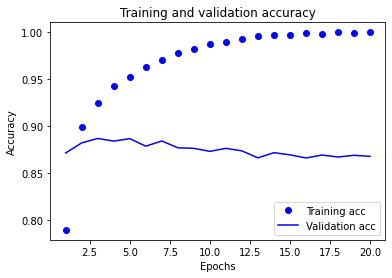

In [9]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that the training accuracy starts off by increasing rapidly with every epoch, and is then eventually slowed down at around epoch three. The validation accuracy is increasing and reaches its peak validation accuracy of 89% at the 4th epoch. The validation accuracy then starts to decrease, meaning this network is overfitting.

The **Optimum Epoch** for the validation accuracy in this network is 3.

# Model 2 - Training with an Embedding layer

The Embedding layer is a dictionary that maps integer indices to dense vectors. It takes integers as inputs and then looks up the integers in an internal dictionary, returning the associated vectors.

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import pandas as pd

### Loading the IMDB data for use with an Embedding layer

In [21]:
from keras.datasets import imdb
from keras import preprocessing
from keras.layers import Embedding

#number of words to consider as features
max_features = 10000
#cuts off the text after this number of words
maxlen = 20

#loads the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words=max_features)

#turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### Building the Model

Code used from the DLWP book. 

Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.

In [23]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()

#specifies the maximum input length to the embedding layer so you can alter faltten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))

#flattens the 3D tensor of embeddings into a 2D tensor og shape
model.add(Flatten())

#adds the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 994us/step - loss: 0.6618 - acc: 0.6370 - val_loss: 0.6006 - val_acc: 0.7082
Epoch 2/10
625/625 [==============================] - 1s 895us/step - loss: 0.5266 - acc: 0.7564 - val_loss: 0.5170 - val_acc: 0.7332
Epoch 3/10
625/625 [==============================] - 1s 929us/step - loss: 0.4552 - acc: 0.7900 - val_loss: 0.4

### Main Results from this Model
| Highest Validation Loss | Lowest Validation Loss | Best Validation Accuracy | Worst Validation Accuracy |
|:-: |:-: |:-: |:-: |
| 0.6006 (Epoch 1) | 0.4915 (Epoch 4) | 0.7568 (Epoch 7) | 0.7082 (Epoch 1)

### Loss Graph

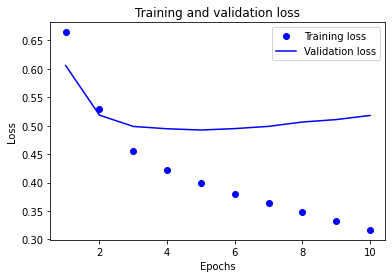

In [17]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
    
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Code for the Labels
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

After reducing the number of epochs to 8 you can see that the graph above shows the training loss starts off rapidly decreasing and then it slows down by the third epoch however it is still decreasing until the end. The validation loss starts off decreasing until epoch 5, inw hich it then starts to increase very slowly till the last epoch. This model is still overfitting.

The **Optimum epoch** for the validation loss in this network is 4.

### Accuracy Graph

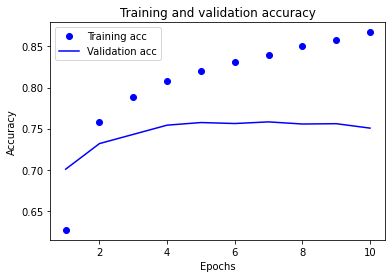

In [18]:
plt.clf()

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
    
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
# Code for the labels
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy increases with every epoch and reaches its peak at 87% at 10 epochs, however the validation accuracy reaches its peak of 76% at 7 epochs and then starts to slowly decrease again. Therefore this model is overfitting.

The **Optimum epoch** for the validation accuracy in this network is 7.

# Model 3 - 1D Convnet

We are not working with images therefore a 2D Convnet will not work, so we will be using a 1D Convnet which works well for processing temporal patterns, and can often perform faster then RNNs on some problems.

### Preparing the IMDB Dataset

In [40]:
from keras.datasets import imdb
from keras.preprocessing import sequence
# number of words to consider as features
max_features = 10000
# cut texts after this number of words (among top max_features most common words)
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


### Building the Network

Code used from DLWP book

Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.

In [48]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
___________________________________________

We have seen an enormous increase in the time taken for each epoch, from the average being around 1 second in the previous embedding layer model, to now moving on in this 1D Convnet model, each epoch rougly takes 30 seconds, and for a model with 20 epochs, it takes approximately 10 minutes to finish running the network. 

### Main Results from this Model
| Highest Validation Loss | Lowest Validation Loss | Best Validation Accuracy | Worst Validation Accuracy |
|:-: |:-: |:-: |:-: |
| 0.6979 (Epoch 20) | 0.3892 (Epoch 7) | 0.8746 (Epoch 14) | 0.5582 (Epoch 1)

## Loss Graph

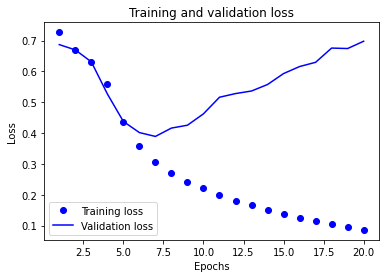

In [49]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
    
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Code for the Labels
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training loss decreases rapidly until the 6th epoch, where it continues to decrease until the last epoch at a more slower rate. The validation loss matches the training loss until the 6th epoch, in which it then takes a sharp turn and starts to increase with every epoch after that, showing signs of heavy overfitting. The number of epochs is too high for this model therefore reducing it would show a better fit.

The **Optimum epoch** for the validation loss in this network is 7.

## Accuracy Graph

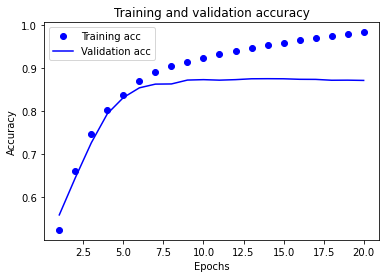

In [50]:
plt.clf()

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
    
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
# Code for the labels
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy has improved reaching 98%, compared to the last model where it hit 87%, although this model has double the epochs, so a higher training accuracy is expected but 98% is alot higher in comparison. The validation accuracy matches the training accuracy up until the 6th epoch, in which it then falls off and remains at a near constant rate for every epoch after. This model is therefore overfitting.

The **Optimum epoch** for the validation accuracy in this network is 14.

# Model 4 - Reducing number of Epochs from Model 3

Here I will be reducing the number of epochs from 20 to 8 to prevent overfitting from the previous model.

### Building the Network

In [51]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=8,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 98, 32)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
___________________________________________

### Main Results from this Model
| Highest Validation Loss | Lowest Validation Loss | Best Validation Accuracy | Worst Validation Accuracy |
|:-: |:-: |:-: |:-: |
| 0.6829 (Epoch 1) | 0.3954 (Epoch 6) | 0.8728 (Epoch 8) | 0.5706 (Epoch 1)

### Loss Graph

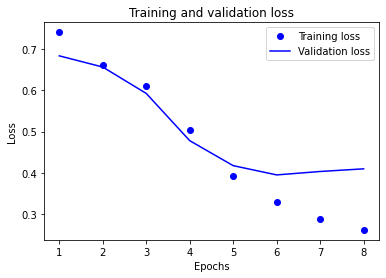

In [52]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
    
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Code for the Labels
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The reduced epoch from the previous graph has greatly improved this model, the training loss and validation loss have a better fit now. The training loss decreases with every epoch, similarly with the validation loss where it also decreases until the 6th epoch in which it then begins to increase. This graph has a good fit until the 6th epoch, where it starts to overfit. This graph is underfitting in the beginning and starts to overfit later on.

The **Optimum epoch** for the validation loss in this network is 6.

### Accuracy Graph

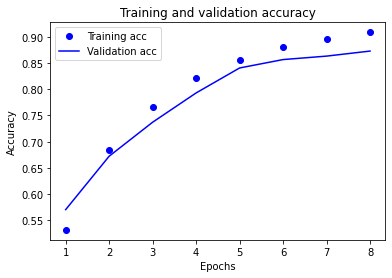

In [53]:
plt.clf()

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
    
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
# Code for the labels
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The accuracy graph seems to have a pretty good fit, some overfitting is present however it is the best graph produced. The training accuracy increases throughout and reaches 91%. The validation accuracy pretty much matches the training accuracy up until the 7th epoch, where it begins to separate itself more and starts to slow down. This graph is slightly overfitting.

The **Optimum epoch** for the validation accuracy in this network is 8.

# Model 5 - Adding GRU Layer

Experimenting further from the previous model by adding a GRU layer, which can be used to prevent overfitting.

### Building the Network

In [70]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=8,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 98, 32)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 92, 32)            7200      
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 1,322,273
Trainable params: 1,322,273
Non-trainable params: 0
___________________________________________

Adding a Gated recurrent unit layer to the previous model increased the time taken for each epoch to rougly 42 seconds, an increase of rougly 10 seconds.

### Main Results from this Model
| Highest Validation Loss | Lowest Validation Loss | Best Validation Accuracy | Worst Validation Accuracy |
|:-: |:-: |:-: |:-: |
| 0.6758 (Epoch 1) | 0.5123 (Epoch 5) | 0.8080 (Epoch 8) | 0.6232 (Epoch 1)

### Loss Graph

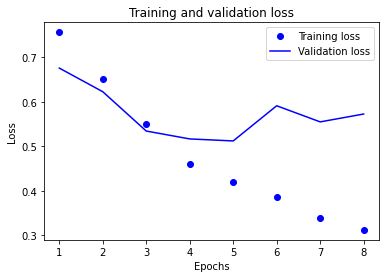

In [71]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
    
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Code for the Labels
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training loss decreases with every epoch whereas the validation loss decreases slowly and then begins to increase and fluctuate alot more, showing very unstable results. This graph is underfitting up until the 3rd epoch, where overfitting is then present. 

The **Optimum epoch** for the validation loss in this network is 5.

### Accuracy Graph

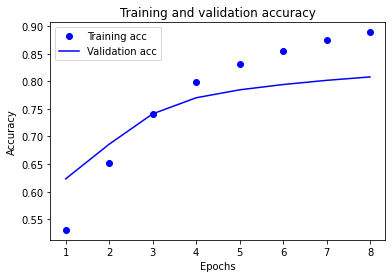

In [72]:
plt.clf()

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
    
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
# Code for the labels
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy increases gradually with every epoch, reaching 88% at epoch 8, a slight decrease from the previous model. The validation accuracy follows a similar trend as the training accuracy however at a much slower rate. This model is underfitting until the 3rd epoch, and then starts to overfit for the following epochs. 

The **Optimum epoch** for the validation accuracy in this network is 8.

# Model 6 - LSTM

LSTM essentially saves information for later, preventing older signals from gradually vanishing during processing.

### Preparing the IMDB Dataset

In [58]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

# number of words to consider as features
max_features = 10000  
# cut texts after this number of words (among top max_features most common words)
maxlen = 500 
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


### Building the Network

Model used from DLWP Book

Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.

In [59]:
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 40s 254ms/step - loss: 0.5071 - acc: 0.7633 - val_loss: 0.3270 - val_acc: 0.8698
Epoch 2/10
157/157 [==============================] - 40s 252ms/step - loss: 0.2911 - acc: 0.8857 - val_loss: 0.3959 - val_acc: 0.8464
Epoch 3/10
157/157 [==============================] - 40s 254ms/step - loss: 0.2283 - acc: 0.9149 - val_loss: 0.2767 - val_acc: 0.8914
Epoch 4/10
157/157 [==============================] - 40s 255ms/step - loss: 0.1980 - acc: 0.9258 - val_loss: 0.3073 - val_acc: 0.8880
Epoch 5/10
157/157 [==============================] - 40s 255ms/step - loss: 0.1752 - acc: 0.9365 - val_loss: 0.3128 - val_acc: 0.8872
Epoch 6/10
157/157 [==============================] - 41s 260ms/step - loss: 0.1555 - acc: 0.9449 - val_loss: 0.3065 - val_acc: 0.8824
Epoch 7/10
157/157 [==============================] - 39s 251ms/step - loss: 0.1425 - acc: 0.9500 - val_loss: 0.4107 - val_acc: 0.8642
Epoch 8/10
157/157 [==============================] - 4

The time taken in this LSTM model is very similar to the previous 1D Convnet model with the GRU layer, taking approximately 40 seconds for each epoch to run. 

### Main Results from this Model
| Highest Validation Loss | Lowest Validation Loss | Best Validation Accuracy | Worst Validation Accuracy |
|:-: |:-: |:-: |:-: |
| 0.4735 (Epoch 9) | 0.2767 (Epoch 3) | 0.8914 (Epoch 3) | 0.8464 (Epoch 2)

### Loss Graph

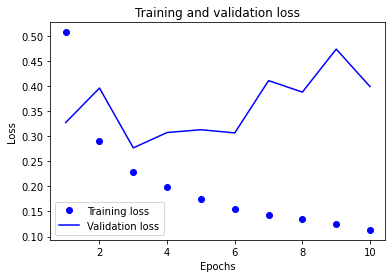

In [60]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
    
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Code for the Labels
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training loss decreases with every epoch, whereas the validation loss fluctuates throughout the model, where it increases and decreases with every epoch, making it very unstable, However the lowest validation loss is 0.2767 which is a big difference from the last model where the lowest validation loss was 0.5123, so it is almost half of what it was in the previous model. Overfitting is present in this graph.

The **Optimum epoch** for the validation loss in this network is 3.

### Accuracy Graph

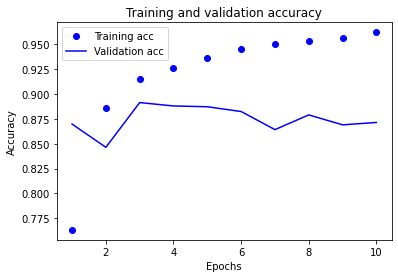

In [61]:
plt.clf()

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
    
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
# Code for the labels
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy jumps massively to epoch 2, where it then increases gradually until the 8th epoch reaching 96%, an increase of 8% from the previous model. The validation accuracy similarly to the loss graph, increases and decreases with every epoch but not as severe in this case. Underfitting is present until the 2nd epoch, where then overfitting is present throughout.

The **Optimum epoch** for the validation accuracy in this network is 3.

# Model 7 - Adding dropout to LSTM

Adding a dropout percentage of 0.5 to the previous model to see how results are affected and to see if overfitting is reduced.

### Building the Network

In [62]:
from keras.layers import LSTM
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 42s 268ms/step - loss: 0.5707 - acc: 0.7310 - val_loss: 0.3608 - val_acc: 0.8556
Epoch 2/10
157/157 [==============================] - 42s 267ms/step - loss: 0.3434 - acc: 0.8708 - val_loss: 0.4178 - val_acc: 0.8378
Epoch 3/10
157/157 [==============================] - 44s 283ms/step - loss: 0.2595 - acc: 0.9050 - val_loss: 0.2748 - val_acc: 0.8858
Epoch 4/10
157/157 [==============================] - 44s 283ms/step - loss: 0.2169 - acc: 0.9211 - val_loss: 0.3329 - val_acc: 0.8620
Epoch 5/10
157/157 [==============================] - 42s 267ms/step - loss: 0.1885 - acc: 0.9336 - val_loss: 0.3262 - val_acc: 0.8576
Epoch 6/10
157/157 [==============================] - 45s 284ms/step - loss: 0.1669 - acc: 0.9421 - val_loss: 0.3792 - val_acc: 0.8604
Epoch 7/10
157/157 [==============================] - 45s 285ms/step - loss: 0.1550 - acc: 0.9466 - val_loss: 0.3040 - val_acc: 0.8866
Epoch 8/10
157/157 [==============================] - 4

Adding dropout to the LSTM Model increased the time taken for each epoch by a few seconds.

### Main Results from this Model
| Highest Validation Loss | Lowest Validation Loss | Best Validation Accuracy | Worst Validation Accuracy |
|:-: |:-: |:-: |:-: |
| 0.4178 (Epoch 2) | 0.2748 (Epoch 3) | 0.8866 (Epoch 7) | 0.8378 (Epoch 2)

### Loss Graph

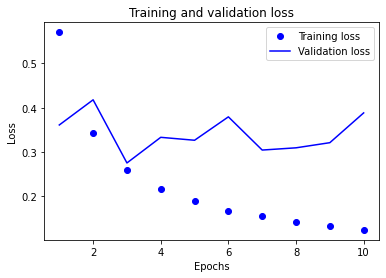

In [63]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
    
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# Code for the Labels
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Adding dropout to this model, has not really changed performance with the graph. The training loss decreases with every epoch, and the validation loss fluctuates with every epoch, increasing and decreasing throughout. This model is overfitting.

The **Optimum epoch** for the validation loss in this network is 3.

### Accuracy Graph

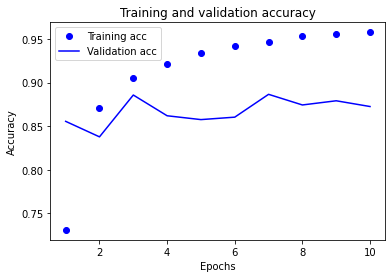

In [64]:
plt.clf()

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
    
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
# Code for the labels
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy increases with every epoch, with the most significant increase happening from epoch 1 to epoch 2, this is then slowed down heavily however continues to increase until the last epoch. The validation accuracy fluctuates throughout the network. Some underfitting is involved in the beginning when the validation accuracy is greater than the training accuracy, however this is for a short time as it begins to overfit from epoch 2 and onwards.

The **Optimum epoch** for the validation accuracy in this network is 7.

# Summary of the Final Models

| Model Number | Layers | Best Validation Acc | Optimum Epoch Accuracy | Lowest Validation Loss | Optimum Epoch Loss
|:-:|:-: |:-: |:-: |:-: |:-: 
| 1 | 16-16-1 | 0.8871 | 3 | 0.2793 | 5 
| 2 | Embedding layer | 0.7568 | 7 | 0.4915 | 4 
| 3 | 1D Convnet (20 Epochs) | 0.8745 | 14 | 0.3892 | 7 
| 4 | 1D Convnet (8 Epochs) | 0.8728 | 8 | 0.3954 | 6 
| 5 | 1D Convnet with GRU Layer | 0.8080 | 8 | 0.5123 | 5 
| 6 | LSTM  | 0.8914 | 3 | 0.2767 | 3 
| 7 | LSTM with dropout | 0.8866 | 7 | 0.2748 | 3 

# Conclusion

I started off by creating a simple 16-16-1 model and running it to see the results that I would get on the IMDB dataset. I felt as though this was a good way to start off and see the results I get and then comparing them with models that use more advanced techniques from the second half of the DLWP book. 

From the table above you can see that I achieved a validation accuracy of around 89% with the lowest validation loss being at around 28% for the first model. These results were pretty good for the first model and better then I expected as a baseline, as it turns out these results were one of the best out of all the models created. I moved on to adding an Embedded layer model, and achieved horrible results, the peak validation accuracy reached, 76% and the peak lowest validation loss was almost 50%, so I found this model for this dataset not ideal. I could have done more experiments on this model, maybe adding more layers and tuning some of the numbers however I felt as though whatever I would do to the model, it would not come close to the numbers Model 1 produced, so I moved onto 1D Convnet. For my first 1D Convnet model with 20 Epochs, the validation accuracy peaked at 87%, and the validation loss was almost 39%, a lot better results then the previous model however still worse then Model 1. The graph produced for this model started with a pretty good fit, so I decided to create a new model with the same inputs as Model 3, but this time reducing the amount of Epochs to 8. This model produced similar validity and loss results because they were the same models, however the graph produced was the best out of all the models, where the training and validation dataset numbers were very similar, and only straying apart towards the later Epochs.

After experimenting with the 1D Convnet models I decided to create a LSTM model, and it produced the highest peak validation accuracy at 89%, as well as the lowest validation loss at 28% which were the best peak results out of all the models created, topping the 16-16-1 model too.  Despite these results this model displayed very heavy overfitting, so I decided to create an additional LSTM model which included a dropout layer at a percentage of 0.5, and this slightly reduced the overfitting and the unstableness present in the graphs for the previous model.

Overall, it was great learning advanced techniques such as Embedded layers, Convnets and LSTM networks and putting them into practise. It was very fascinating to see the different results and comparing them with the previous coursework. I felt as though these techniques are a lot harder to implement and get right because you need a deeper understanding of the work, as well as the models require more fine tuning and time to run, sometimes making trial and error in this case quite frustrating due to having to wait a substantial amount of time for each epoch.

For the future, if I was to develop this even further, I would solely focus on the 1D Convnet model, because it produced good results as well as an adequate good to fit graph, so I feel as though with some more experimentation, I would be capable of creating a good model.

#### Reference(s)
Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.